# Baseline Linear Regression 

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
df = pd.read_csv('modeling_data_sample.csv')
print(df.shape)
df.head()

(150, 18)


,TEAM_SEASON,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT,PO_WINS,TEAM_ID,TEAM_NAME,PO_WINS_CAT
0,1610612737_2019-20,19.856225,0.517043,0.252180,0.149825,0.226813,0.526620,0.313881,0.133524,0.235405,78.812500,217.250000,3.687500,0.354,0.0,1610612737,Hawks,R1/Lottery
1,1610612737_2020-21,24.459721,0.519798,0.257725,0.148807,0.214129,0.536863,0.277694,0.142510,0.234664,78.235294,216.058824,3.823529,0.299,10.0,1610612737,Hawks,Conf. Finals
2,1610612737_2021-22,19.359828,0.527291,0.280572,0.134667,0.223747,0.535920,0.260534,0.126992,0.220961,78.352941,212.882353,4.411765,0.569,1.0,1610612737,Hawks,R1/Lottery
3,1610612737_2022-23,19.634129,0.515657,0.252946,0.140765,0.214893,0.532730,0.251615,0.131051,0.222704,78.352941,212.705882,2.823529,0.524,2.0,1610612737,Hawks,R1/Lottery
4,1610612737_2023-24,17.248412,0.555474,0.240233,0.135582,0.279755,0.537575,0.270382,0.132214,0.209344,78.352941,212.705882,3.823529,0.500,NaN,1610612737,Hawks,NaN


In [3]:
def modeling_data_setup(data,test_seasons,this_season,model_type):
    # returns x, xtest, y, ytest, this season's data 
    
    import pandas as pd
    import numpy as np 
    
    if type(test_seasons) == int:
        test_seasons = [test_seasons]
    elif type(test_seasons) == list:
        test_seasons = test_seasons
    else:
        raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
        
    for i in test_seasons:
        if type(i)!=int:
            raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
    
    import pandas as pd
    import numpy as np 
    from sklearn.model_selection import train_test_split
    
    print('columns to drop:')
    drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','PO_WINS_CAT','SEASON']
    print(drop_cols)
    
    print('Model Type: {}'.format(model_type))
    if model_type == 'cat':
        target = 'PO_WINS_CAT'
    elif model_type == 'reg':
        target = 'PO_WINS'
    else:
        raise TypeError("ERROR! Enter model_type! Options: 'cat' or 'reg'")
    
    print('Creating SEASON for splitting')
    ids = data['TEAM_SEASON'].str.split('_')
    season = [int(x[1][0:4]) for x in ids]
    data['SEASON'] = season
    
    print("Dropping this season: {}".format(this_season))
    current = data[data['SEASON']==this_season].copy()
    
    test = data[data['SEASON'].isin(test_seasons)].copy()
    train = data[(~data['SEASON'].isin(test_seasons))&(data['SEASON']!=this_season)].copy()
    ytest = test[target].copy()
    ytrain = train[target].copy()
    xtest = test.drop(drop_cols,axis=1)
    xtrain = train.drop(drop_cols,axis=1)
    
    print("Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season")
    
    return train,test,xtrain,xtest,ytrain,ytest,current

In [4]:
train, test, x_train, x_test, y_train, y_test, upcoming = modeling_data_setup(df,[2022,2021],2023,'reg')

columns to drop:
['TEAM_SEASON', 'TEAM_ID', 'TEAM_NAME', 'PO_WINS', 'PO_WINS_CAT', 'SEASON']
Model Type: reg
Creating SEASON for splitting
Dropping this season: 2023
Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season


In [5]:
id_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','SEASON']
train_ids = train[id_cols].copy()
test_ids = test[id_cols].copy()

## Modeling

In [6]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

In [7]:
param_grid = {
                'alpha'     : [0.1,1,10,0.01],
                'l1_ratio'  :  np.arange(0.40,1.00,0.10),
                'tol'       : [0.0001,0.001]
            }
eNet = ElasticNet(max_iter=10000)
clf = GridSearchCV(eNet, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 5,
                           return_train_score=True,
                           n_jobs = -1)

In [8]:
# Fitting the model 
clf.fit(x_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Best Score :",clf.best_score_)

Tuned Hyperparameters : {'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}
Best Score : -3.8399358076433616


In [9]:
# storing the CV results 
cv = pd.DataFrame(clf.cv_results_)

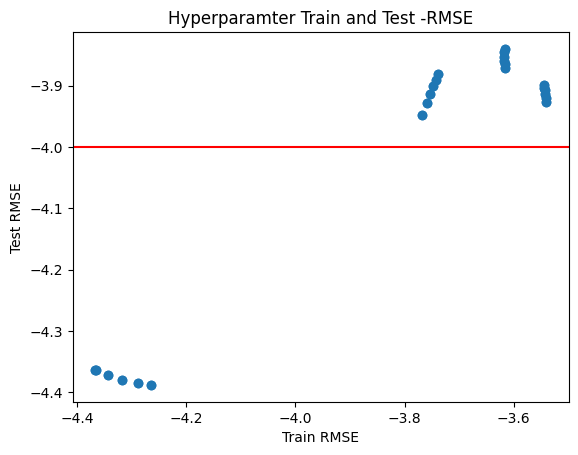

In [10]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [11]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_tol,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003139,0.000165,0.001428,0.000098,0.1,0.4,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",-3.632029,-5.329442,...,-3.839936,1.094655,1,-3.708472,-3.207059,-3.648507,-3.546758,-3.972657,-3.616691,0.248531
1,0.003004,0.000062,0.001413,0.000025,0.1,0.4,0.001,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.001}",-3.632021,-5.329533,...,-3.839950,1.094675,2,-3.708472,-3.207051,-3.648506,-3.546756,-3.972653,-3.616688,0.248532
2,0.003068,0.000072,0.001384,0.000083,0.1,0.5,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.5, 'tol': 0.0001}",-3.636576,-5.343581,...,-3.845658,1.099624,3,-3.709929,-3.202833,-3.650438,-3.548174,-3.973195,-3.616914,0.250160
3,0.003084,0.000083,0.001421,0.000047,0.1,0.5,0.001,"{'alpha': 0.1, 'l1_ratio': 0.5, 'tol': 0.001}",-3.636562,-5.343674,...,-3.845672,1.099644,4,-3.709929,-3.202826,-3.650437,-3.548173,-3.973191,-3.616911,0.250161
4,0.002803,0.000236,0.001344,0.000030,0.1,0.6,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.6, 'tol': 0.0001}",-3.643010,-5.359805,...,-3.852839,1.105205,5,-3.711995,-3.197589,-3.653078,-3.550043,-3.973883,-3.617317,0.252222
5,0.002007,0.000056,0.001283,0.000039,0.1,0.6,0.001,"{'alpha': 0.1, 'l1_ratio': 0.6, 'tol': 0.001}",-3.643000,-5.359899,...,-3.852857,1.105227,6,-3.711995,-3.197582,-3.653076,-3.550043,-3.973878,-3.617315,0.252223
6,0.002216,0.000154,0.001471,0.000214,0.1,0.7,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.7, 'tol': 0.0001}",-3.652647,-5.378917,...,-3.859519,1.111588,7,-3.715117,-3.190743,-3.653606,-3.552603,-3.974807,-3.617375,0.254886
7,0.002136,0.000120,0.001325,0.000045,0.1,0.7,0.001,"{'alpha': 0.1, 'l1_ratio': 0.7, 'tol': 0.001}",-3.652643,-5.379005,...,-3.859537,1.111607,8,-3.715119,-3.190738,-3.653604,-3.552602,-3.974802,-3.617373,0.254886
8,0.002002,0.000105,0.001255,0.000043,0.1,0.8,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.7999999999999999,...",-3.654958,-5.402445,...,-3.864930,1.119192,9,-3.715948,-3.181109,-3.654140,-3.555580,-3.976153,-3.616586,0.258431
9,0.002065,0.000131,0.001295,0.000038,0.1,0.8,0.001,"{'alpha': 0.1, 'l1_ratio': 0.7999999999999999,...",-3.654982,-5.402515,...,-3.864948,1.119204,10,-3.715952,-3.181107,-3.654138,-3.555580,-3.976146,-3.616585,0.258430


In [12]:
clf.best_estimator_.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.4,
 'max_iter': 10000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [13]:
cv[cv['mean_test_score']==max(cv['mean_test_score'])]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_tol,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003139,0.000165,0.001428,0.000098,0.1,0.4,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",-3.632029,-5.329442,...,-3.839936,1.094655,1,-3.708472,-3.207059,-3.648507,-3.546758,-3.972657,-3.616691,0.248531


## Evaluation

### Train 

In [14]:
predictions = clf.predict(x_train)

In [15]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [16]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['TEAM_NAME']
train_output['Season'] = train['SEASON']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [17]:
train_output.head()

,Actual,Prediction,Team,Season
135,0.0,-1.137861,Wizards,2019
95,0.0,-0.054207,Suns,2019
145,0.0,-0.039797,Hornets,2019
130,0.0,0.048807,Grizzlies,2019
35,0.0,0.361833,Warriors,2019


In [18]:
train_results

,MSE,MAE,R2,RMSE
1,13.434193,2.697868,0.303687,3.665268


### Test 

In [19]:
predictions = clf.predict(x_test)

In [20]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [21]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['TEAM_NAME']
test_output['Season'] = test['SEASON']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [22]:
test_output.head()

,Actual,Prediction,Team,Season
117,0.0,-2.169136,Thunder,2021
132,6.0,-1.127434,Grizzlies,2021
112,0.0,-0.950649,Spurs,2021
142,0.0,-0.938330,Pistons,2021
122,2.0,-0.176348,Raptors,2021


In [23]:
test_results

,MSE,MAE,R2,RMSE
1,17.463474,3.132404,0.083803,4.178932


### Upcoming Season 

In [24]:
x_up = upcoming[clf.best_estimator_.feature_names_in_]
x_up.head()

,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT
4,17.248412,0.555474,0.240233,0.135582,0.279755,0.537575,0.270382,0.132214,0.209344,78.352941,212.705882,3.823529,0.500
9,18.700720,0.567396,0.221128,0.139701,0.204178,0.548612,0.247778,0.127512,0.215784,79.000000,224.941176,6.647059,0.695
14,16.507773,0.530249,0.235302,0.161822,0.227790,0.524138,0.278149,0.153087,0.218486,78.176471,218.588235,5.882353,0.622
19,17.913739,0.524626,0.296855,0.137225,0.239270,0.539656,0.264343,0.142655,0.217808,78.588235,214.058824,5.000000,0.512
24,19.072808,0.560886,0.257995,0.122774,0.212824,0.535775,0.251967,0.159039,0.203952,78.058824,212.000000,5.588235,0.488


In [25]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['TEAM_NAME']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
119,Thunder,-1.559301,-2,R1/Lottery
149,Hornets,-0.092561,0,R1/Lottery
44,Rockets,0.775204,1,R1/Lottery
139,Wizards,0.977054,1,R1/Lottery
4,Hawks,1.105003,1,R1/Lottery
114,Spurs,1.594404,2,R1/Lottery
104,Trail Blazers,1.990369,2,R1/Lottery
109,Kings,2.157790,2,R1/Lottery
89,Pacers,2.249752,2,R1/Lottery
84,Magic,2.380979,2,R1/Lottery


In [26]:
len(list(final_output['Team']))

30

In [27]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [28]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [38]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
94,76ers,5.969243,6,Second Round
59,Heat,6.755290,7,Second Round
9,Celtics,6.911123,7,Second Round
64,Bucks,8.067548,8,Conf. Finals


In [39]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
54,Lakers,4.637758,5,Second Round
49,Clippers,5.902031,6,Second Round
99,Suns,6.612389,7,Second Round
34,Nuggets,6.617499,7,Second Round


In [40]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
34,Nuggets,6.617499,7,Second Round
59,Heat,6.755290,7,Second Round
9,Celtics,6.911123,7,Second Round
64,Bucks,8.067548,8,Conf. Finals


## Writing Info 

In [41]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [42]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,13.434193,2.697868,0.303687,3.665268,TRAIN
1,17.463474,3.132404,0.083803,4.178932,TEST


In [43]:
model_name = input()

logreg_first_sample


In [44]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

logreg_first_sample_cv_results.csv
logreg_first_sample_output.csv
logreg_first_sample_results.csv
logreg_first_sample_full_predictions.csv
logreg_first_sample_ecf_predictions.csv
logreg_first_sample_wcf_predictions.csv
logreg_first_sample_finals_predictions.csv


In [45]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [47]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)